<a href="https://colab.research.google.com/github/icekang/NLP_2021/blob/main/hw3_pos_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 3 - Neural POS Tagger

In this exercise, you are going to build a set of deep learning models on part-of-speech (POS) tagging using Tensorflow 2. Tensorflow is a deep learning framwork developed by Google to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for POS tagging in Thai using NECTEC's ORCHID corpus. You will build one model for each of the following type:

- Neural POS Tagging with Word Embedding using Fixed / non-Fixed Pretrained weights
- Neural POS Tagging with Viterbi / Marginal CRF

Pretrained word embeddding are already given for you to use (albeit, a very bad one).

We also provide the code for data cleaning, preprocessing and some starter code for tensorflow 2 in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

### Don't forget to change hardware accelrator to GPU in runtime on Google Colab ###

## 1. Setup and Preprocessing

We use POS data from [ORCHID corpus](https://www.nectec.or.th/corpus/index.php?league=pm), which is a POS corpus for Thai language.
A method used to read the corpus into a list of sentences with (word, POS) pairs have been implemented already. The example usage has shown below.
We also create a word vector for unknown word by random.

In [1]:
%tensorflow_version 2.x

In [2]:
!wget https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
!unzip resources.zip

--2021-02-06 16:48:08--  https://www.dropbox.com/s/tuvrbsby4a5axe0/resources.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tuvrbsby4a5axe0/resources.zip [following]
--2021-02-06 16:48:09--  https://www.dropbox.com/s/raw/tuvrbsby4a5axe0/resources.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc117d3e918940fbfaf89cd98282.dl.dropboxusercontent.com/cd/0/inline/BIZfU2dMXuqGCaSJrokXyFO5wOohZtGMiXsB0BbElor9lCRzBvkqXk8tnpLGLP1TPkYMmqRsy9MfeeD1KbzB93VP5Iw704KAS1d7by_M35D8Fg/file# [following]
--2021-02-06 16:48:09--  https://uc117d3e918940fbfaf89cd98282.dl.dropboxusercontent.com/cd/0/inline/BIZfU2dMXuqGCaSJrokXyFO5wOohZtGMiXsB0BbElor9lCRzBvkqXk8tnpLGLP1TPkYMmqRsy9MfeeD1KbzB93VP5Iw704KAS1d7by_M35D8Fg/file
Resolving 

In [3]:
!pip install python-crfsuite
!pip install tensorflow-addons
!pip install tf2crf

     |████████████████████████████████| 747kB 6.1MB/s 


In [4]:
%tensorflow_version 2.x

In [5]:
from data.orchid_corpus import get_sentences
import numpy as np
import numpy.random
import tensorflow as tf
np.random.seed(42)

In [6]:
yunk_emb =np.random.randn(32)
train_data = get_sentences('train')
test_data = get_sentences('test')
print(train_data[0])

[('การ', 'FIXN'), ('ประชุม', 'VACT'), ('ทาง', 'NCMN'), ('วิชาการ', 'NCMN'), ('<space>', 'PUNC'), ('ครั้ง', 'CFQC'), ('ที่ 1', 'DONM')]


Next, we load pretrained weight embedding using pickle. The pretrained weight is a dictionary which map a word to its embedding.

In [7]:
import pickle
fp = open('basic_ff_embedding.pt', 'rb')
embeddings = pickle.load(fp)
fp.close()

The given code below generates an indexed dataset(each word is represented by a number) for training and testing data. The index 0 is reserved for padding to help with variable length sequence. (Additionally, You can read more about padding here [https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/])

## 2. Prepare Data

In [8]:
word_to_idx ={}
idx_to_word ={}
label_to_idx = {}
for sentence in train_data:
    for word,pos in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)+1
            idx_to_word[word_to_idx[word]] = word
        if pos not in label_to_idx:
            label_to_idx[pos] = len(label_to_idx)+1
word_to_idx['UNK'] = len(word_to_idx)

n_classes = len(label_to_idx.keys())+1

This section is tweaked a little from the demo, word2features will return word index instead of features, and sent2labels will return a sequence of word indices in the sentence.

In [9]:
def word2features(sent, i, emb):
    word = sent[i][0]
    if word in word_to_idx :
        return word_to_idx[word]
    else :
        return word_to_idx['UNK']

def sent2features(sent, emb_dict):
    return np.asarray([word2features(sent, i, emb_dict) for i in range(len(sent))])

def sent2labels(sent):
    return numpy.asarray([label_to_idx[label] for (word, label) in sent],dtype='int32')

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [10]:
sent2features(train_data[100], embeddings)

array([ 29, 327,   5, 328])

Next we create train and test dataset, then we use tensorflow 2 to post-pad the sequence to max sequence with 0. Our labels are changed to a one-hot vector.

In [25]:
%%time
x_train = np.asarray([sent2features(sent, embeddings) for sent in train_data])
y_train = [sent2labels(sent) for sent in train_data]
x_test = [sent2features(sent, embeddings) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]

CPU times: user 272 ms, sys: 1.11 ms, total: 273 ms
Wall time: 273 ms


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
display(np.eye(n_classes))
display(y_train[100])
display(np.eye(n_classes)[y_train[100]])
display(np.eye(n_classes)[y_train[100]][np.newaxis,:])
a = np.array([1,2,3])
np.eye(n_classes)[[3,1]]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

array([ 3, 10,  4,  3], dtype=int32)

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

array([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [34]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
y_train=tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=None, dtype='int32', padding='post', truncating='pre', value=0.)
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=102, dtype='int32', padding='post', truncating='pre', value=0.)
y_temp =[]
for i in range(len(y_train)):
    y_temp.append(np.eye(n_classes)[y_train[i]][np.newaxis,:]) # to one-hot
y_train = np.asarray(y_temp).reshape(-1,102,n_classes)
del(y_temp)

In [35]:
print(x_train[100],x_train.shape)
print(y_train[100][3],y_train.shape)

[ 29 327   5 328   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0] (18500, 102)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (18500, 102, 48)


## 3. Evaluate

Our output from tf keras is a distribution of problabilities on all possible label. outputToLabel will return an indices of maximum problability from output sequence.

evaluation_report is the same as in the demo

In [36]:
def outputToLabel(yt,seq_len):
    out = []
    for i in range(0,len(yt)):
        if(i==seq_len):
            break
        out.append(np.argmax(yt[i]))
    return out

In [37]:
import pandas as pd
from IPython.display import display

def evaluation_report(y_true, y_pred):
    # retrieve all tags in y_true
    tag_set = set()
    for sent in y_true:
        for tag in sent:
            tag_set.add(tag)
    for sent in y_pred:
        for tag in sent:
            tag_set.add(tag)
    tag_list = sorted(list(tag_set))
    
    # count correct points
    tag_info = dict()
    for tag in tag_list:
        tag_info[tag] = {'correct_tagged': 0, 'y_true': 0, 'y_pred': 0}

    all_correct = 0
    all_count = sum([len(sent) for sent in y_true])
    for sent_true, sent_pred in zip(y_true, y_pred):
        for tag_true, tag_pred in zip(sent_true, sent_pred):
            if tag_true == tag_pred:
                tag_info[tag_true]['correct_tagged'] += 1
                all_correct += 1
            tag_info[tag_true]['y_true'] += 1
            tag_info[tag_pred]['y_pred'] += 1
    accuracy = (all_correct / all_count) * 100
            
    # summarize and make evaluation result
    eval_list = list()
    for tag in tag_list:
        eval_result = dict()
        eval_result['tag'] = tag
        eval_result['correct_count'] = tag_info[tag]['correct_tagged']
        precision = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_pred'])*100 if tag_info[tag]['y_pred'] else '-'
        recall = (tag_info[tag]['correct_tagged']/tag_info[tag]['y_true'])*100 if (tag_info[tag]['y_true'] > 0) else 0
        eval_result['precision'] = precision
        eval_result['recall'] = recall
        eval_result['f_score'] = (2*precision*recall)/(precision+recall) if (type(precision) is float and recall > 0) else '-'
        
        eval_list.append(eval_result)

    eval_list.append({'tag': 'accuracy=%.2f' % accuracy, 'correct_count': '', 'precision': '', 'recall': '', 'f_score': ''})
    
    df = pd.DataFrame.from_dict(eval_list)
    df = df[['tag', 'precision', 'recall', 'f_score', 'correct_count']]
    display(df)

## 4. Train a model

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking
from tensorflow.keras.optimizers import Adam

The model is this section is separated to two groups

- Neural POS Tagger (4.1)
- Neural CRF POS Tagger (4.2)

## 4.1.1 Neural POS Tagger  (Example)

We create a simple Neural POS Tagger as an example for you. This model dosen't use any pretrained word embbeding so it need to use Embedding layer to train the word embedding from scratch.

Instead of using tensorflow.keras.models.Sequential, we use tensorflow.keras.models.Model. The latter is better as it can have multiple input/output, of which Sequential model could not. Due to this reason, the Model class is widely used for building a complex deep learning model.

In [39]:
inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = TimeDistributed(Dense(n_classes,activation='softmax'))(output)
model = Model(inputs, output)
model.compile(optimizer=Adam(lr=0.001),  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()
model.fit(x_train,y=y_train, batch_size=64,epochs=10,verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 102)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 102, 32)           480608    
_________________________________________________________________
bidirectional (Bidirectional (None, 102, 64)           12672     
_________________________________________________________________
dropout (Dropout)            (None, 102, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 102, 48)           3120      
Total params: 496,400
Trainable params: 496,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
290/290 [==============================] - 13s 14ms/step - loss: 0.3907 - categorical_accuracy: 0.3532
Epoch 2

In [40]:
%%time
model.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1)

Epoch 1/10
290/290 [==============================] - 4s 14ms/step - loss: 0.0180 - categorical_accuracy: 0.9619
Epoch 2/10
290/290 [==============================] - 4s 14ms/step - loss: 0.0174 - categorical_accuracy: 0.9631
Epoch 3/10
290/290 [==============================] - 4s 15ms/step - loss: 0.0167 - categorical_accuracy: 0.9644
Epoch 4/10
290/290 [==============================] - 4s 15ms/step - loss: 0.0162 - categorical_accuracy: 0.9652
Epoch 5/10
290/290 [==============================] - 4s 15ms/step - loss: 0.0155 - categorical_accuracy: 0.9666
Epoch 6/10
290/290 [==============================] - 4s 14ms/step - loss: 0.0150 - categorical_accuracy: 0.9676
Epoch 7/10
290/290 [==============================] - 4s 14ms/step - loss: 0.0146 - categorical_accuracy: 0.9684
Epoch 8/10
290/290 [==============================] - 4s 14ms/step - loss: 0.0141 - categorical_accuracy: 0.9694
Epoch 9/10
290/290 [==============================] - 4s 14ms/step - loss: 0.0137 - categorical_

In [42]:
%%time
model.save_weights('data/my_pos_no_crf.h5')
#model.load_weights('data/my_pos_no_crf.h5')
y_pred=model.predict(x_test)
ypred = [outputToLabel(y_pred[i],len(y_test[i])) for i in range(len(y_pred))]
evaluation_report(y_test, ypred)

,tag,precision,recall,f_score,correct_count
0,1,99.8095,99.5387,99.6739,3668
1,2,94.6542,93.5984,94.1234,7720
2,3,90.5368,96.0744,93.2234,16226
3,4,99.9378,99.4196,99.678,12847
4,5,88,98.5075,92.9577,66
5,6,98.7552,91.1877,94.8207,476
6,7,96.884,97.2102,97.0468,2021
7,8,71.6783,49.3976,58.4879,205
8,9,58.9202,68.2065,63.2242,251
9,10,63.1858,42.5507,50.8547,357


CPU times: user 3.11 s, sys: 136 ms, total: 3.25 s
Wall time: 2.83 s


## 4.2 CRF Viterbi

Your next task is to incorporate Conditional random fields (CRF) to your model.

To use the CRF layer, you need to use an extension repository for tensorflow library, call tf2crf. If you want to see the detailed implementation, you should read the official tensorflow extention of CRF (https://www.tensorflow.org/addons/api_docs/python/tfa/text).

tf2crf link :  https://github.com/xuxingya/tf2crf

For inference, you should look at crf.py at the method call and view the input/output argmunets. 
Link : https://github.com/xuxingya/tf2crf/blob/master/tf2crf/crf.py




### 4.2.1 CRF without pretrained weight
### #TODO 1
Incoperate CRF layer to your model in 4.1. CRF is quite complex compare to previous example model, so you should train it with more epoch, so it can converge.

To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Do not forget to save this model weight.

In [126]:
from tf2crf import CRF, ModelWithCRFLoss

inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = Dense(n_classes,activation=None)(output)
output = CRF(dtype='float32')(output)
model = ModelWithCRFLoss(Model(inputs, output))
model.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])

# model.build((64, 102,))
# model.summary()
model.fit(x_train,y=np.argmax(y_train, axis=2), batch_size=1024,epochs=50,verbose=1)

Epoch 1/50
19/19 [==============================] - 12s 185ms/step - crf_loss: 56.1948 - accuracy: 0.0559
Epoch 2/50
19/19 [==============================] - 3s 183ms/step - crf_loss: 47.9553 - accuracy: 0.2887
Epoch 3/50
19/19 [==============================] - 3s 183ms/step - crf_loss: 38.9276 - accuracy: 0.2736
Epoch 4/50
19/19 [==============================] - 3s 184ms/step - crf_loss: 35.5557 - accuracy: 0.3363
Epoch 5/50
19/19 [==============================] - 4s 187ms/step - crf_loss: 32.8278 - accuracy: 0.4139
Epoch 6/50
19/19 [==============================] - 3s 184ms/step - crf_loss: 28.0864 - accuracy: 0.5017
Epoch 7/50
19/19 [==============================] - 3s 183ms/step - crf_loss: 23.7575 - accuracy: 0.5804
Epoch 8/50
19/19 [==============================] - 4s 188ms/step - crf_loss: 19.6386 - accuracy: 0.6828
Epoch 9/50
19/19 [==============================] - 4s 185ms/step - crf_loss: 15.6268 - accuracy: 0.7822
Epoch 10/50
19/19 [==============================] - 4

In [127]:
%%time
model.save_weights('data/my_pos_with_crf_no_pretrained.h5')
#model.load_weights('data/my_pos_with_crf_no_pretrained.h5')
y_pred=model.predict(x_test)
evaluation_report(y_test, y_pred[0])

,tag,precision,recall,f_score,correct_count
0,0,-,0,-,0
1,1,99.864,99.6201,99.7419,3671
2,2,94.7936,93.8167,94.3026,7738
3,3,90.2791,96.7257,93.3913,16336
4,4,99.8603,99.5898,99.7249,12869
5,5,95.6522,98.5075,97.0588,66
6,6,99.7817,87.5479,93.2653,457
7,7,97.4568,97.6912,97.5739,2031
8,8,71.0843,42.6506,53.3133,177
9,9,72.1154,61.1413,66.1765,225


CPU times: user 19.6 s, sys: 3.3 s, total: 22.9 s
Wall time: 9.39 s



### 4.2.2 CRF with pretrained weight

### #TODO 2

We would like you create a neural CRF POS tagger model  with the pretrained word embedding as an input and the word embedding is trainable (not fixed). To finish this excercise you must train the model and show the evaluation report with this model as shown in the example.

Please note that the given pretrained word embedding only have weights for the vocabuary in BEST corpus.

Optionally, you can use your own pretrained word embedding.

#### Hint: You can get the embedding from get_embeddings function from embeddings/emb_reader.py . 

(You may want to read about Tensorflow Masking layer and Trainable parameter)

In [124]:
from embeddings.emb_reader import get_embeddings
from tf2crf import CRF, ModelWithCRFLoss

embeddings_index = get_embeddings()
embedding_dim = 64
num_tokens = len(word_to_idx)
hits = misses = 0

embedding_matrix = np.random.uniform(-3,3,(num_tokens, embedding_dim))
for word, i in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(
    len(word_to_idx),
    embedding_dim,
    input_length=102,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=True
    ))(inputs)
output = Bidirectional(GRU(embedding_dim, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = Dense(n_classes,activation=None)(output)
output = Masking()(output)
output = CRF(dtype='float32')(output)
model = ModelWithCRFLoss(Model(inputs, output))
model.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])

# model.build((64, 102,))
# model.summary()
model.fit(x_train,y=np.argmax(y_train, axis=2), batch_size=1024,epochs=50,verbose=1)

Converted 3706 words (11313 misses)
Epoch 1/50
19/19 [==============================] - 11s 196ms/step - crf_loss: 370.4845 - accuracy: 0.0399
Epoch 2/50
19/19 [==============================] - 4s 196ms/step - crf_loss: 369.8357 - accuracy: 0.0599
Epoch 3/50
19/19 [==============================] - 4s 199ms/step - crf_loss: 358.6241 - accuracy: 0.0662
Epoch 4/50
19/19 [==============================] - 4s 193ms/step - crf_loss: 348.4626 - accuracy: 0.0801
Epoch 5/50
19/19 [==============================] - 4s 197ms/step - crf_loss: 338.6010 - accuracy: 0.2040
Epoch 6/50
19/19 [==============================] - 4s 197ms/step - crf_loss: 329.1680 - accuracy: 0.3702
Epoch 7/50
19/19 [==============================] - 4s 206ms/step - crf_loss: 318.2252 - accuracy: 0.9551
Epoch 8/50
19/19 [==============================] - 4s 200ms/step - crf_loss: 310.4544 - accuracy: 0.9683
Epoch 9/50
19/19 [==============================] - 4s 201ms/step - crf_loss: 302.1448 - accuracy: 0.9737
Epoch 10/

In [125]:
%%time
model.save_weights('data/my_pos_with_crf_with_pretrained.h5')
#model.load_weights('data/my_pos_with_crf_with_pretrained.h5')
y_pred=model.predict(x_test)
evaluation_report(y_test, y_pred[0])

,tag,precision,recall,f_score,correct_count
0,0,-,0,-,0
1,1,99.8368,99.5929,99.7147,3670
2,2,94.1463,93.5984,93.8716,7720
3,3,89.7101,96.7375,93.0914,16338
4,4,99.8989,99.3732,99.6353,12841
5,5,91.6667,98.5075,94.964,66
6,6,99.345,87.1648,92.8571,455
7,7,98.1562,97.3064,97.7295,2023
8,8,70.9677,53.012,60.6897,220
9,9,74.5387,54.8913,63.2238,202


CPU times: user 20.3 s, sys: 3.18 s, total: 23.5 s
Wall time: 9.73 s


### #TODO 3
Compare the result between all neural tagger models in 4.1 and 4.2.x and provide a convincing reason and example for the result of these models (which model perform better, why?)

(If you use your own weight please state so in the answer)

<b>Write your answer here :</b><br>
#### f1 distribution
4.2.x performs a little bit better in terms of accuracy (93.23 vs 92.98) and f1 score across tags, though not discerningly different

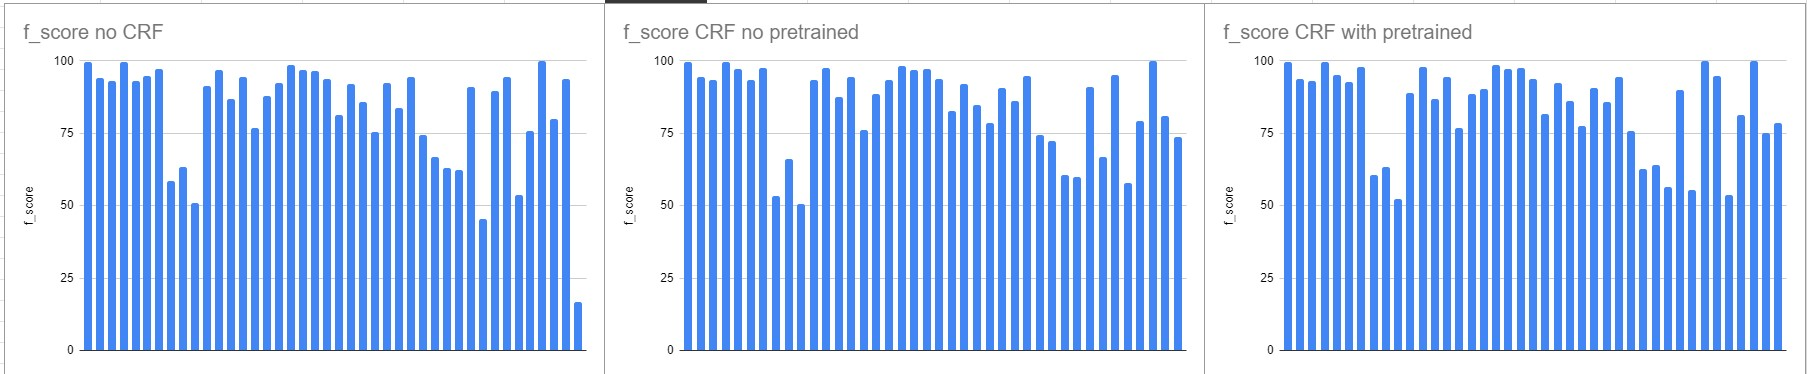



#### f1_difference
Below shows <br>
$\Delta(f1\_score \times correct\_count)$ of 4.2.1 and 4.1<br>
4.2.1 shows better f1 score across tags<br>



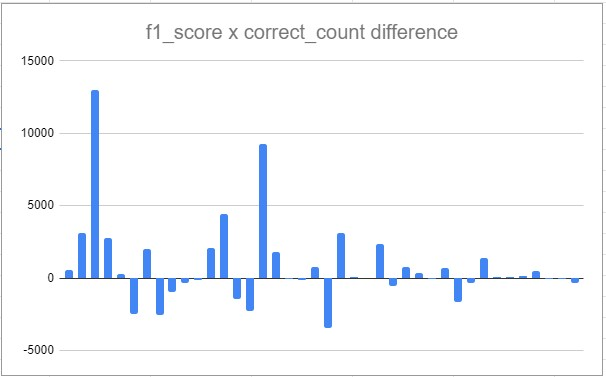

#### Possible reason
This may be due to CRF provide more meaningful insight to the model. Transition matrix holds linguistic ration that model could use to predict the POS. However, it needs more training and more data to converge.

### #TODO 4

Upon inference, the model also returns its transition matrix, which is learned during training. Your task is to observe and report whether the returned matrix is sensible. You can provide some examples to support your argument.

#### Hint : The transition matrix must have the shape  of (num_class, num_class).

<b>Write your answer here :</b>

#### First let's load back our model

In [152]:
from tf2crf import CRF, ModelWithCRFLoss

inputs = Input(shape=(102,), dtype='int32')
output = (Embedding(len(word_to_idx),32,input_length=102,mask_zero=True))(inputs)
output = Bidirectional(GRU(32, return_sequences=True))(output)
output = Dropout(0.2)(output)
output = Dense(n_classes,activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
model = ModelWithCRFLoss(Model(inputs, output))
# model.compile(optimizer=Adam(lr=0.001), metrics=['categorical_accuracy'])
model.built = True
model.load_weights('data/my_pos_with_crf_no_pretrained.h5')
y_pred=model.predict(x_test)

#### Now we'll prepare idx_to_label which maps idx of pos back to pos

In [181]:
idx_to_label = dict()

for label in label_to_idx:
  # print(label, label_to_idx[label])
  idx_to_label[label_to_idx[label]] = label

# for i,v in enumerate(crf.transitions[label_to_idx['ADVN']].numpy()):
#   print(idx_to_label.get(i),v)

#### Fun part: let's visualize the transition matrix!

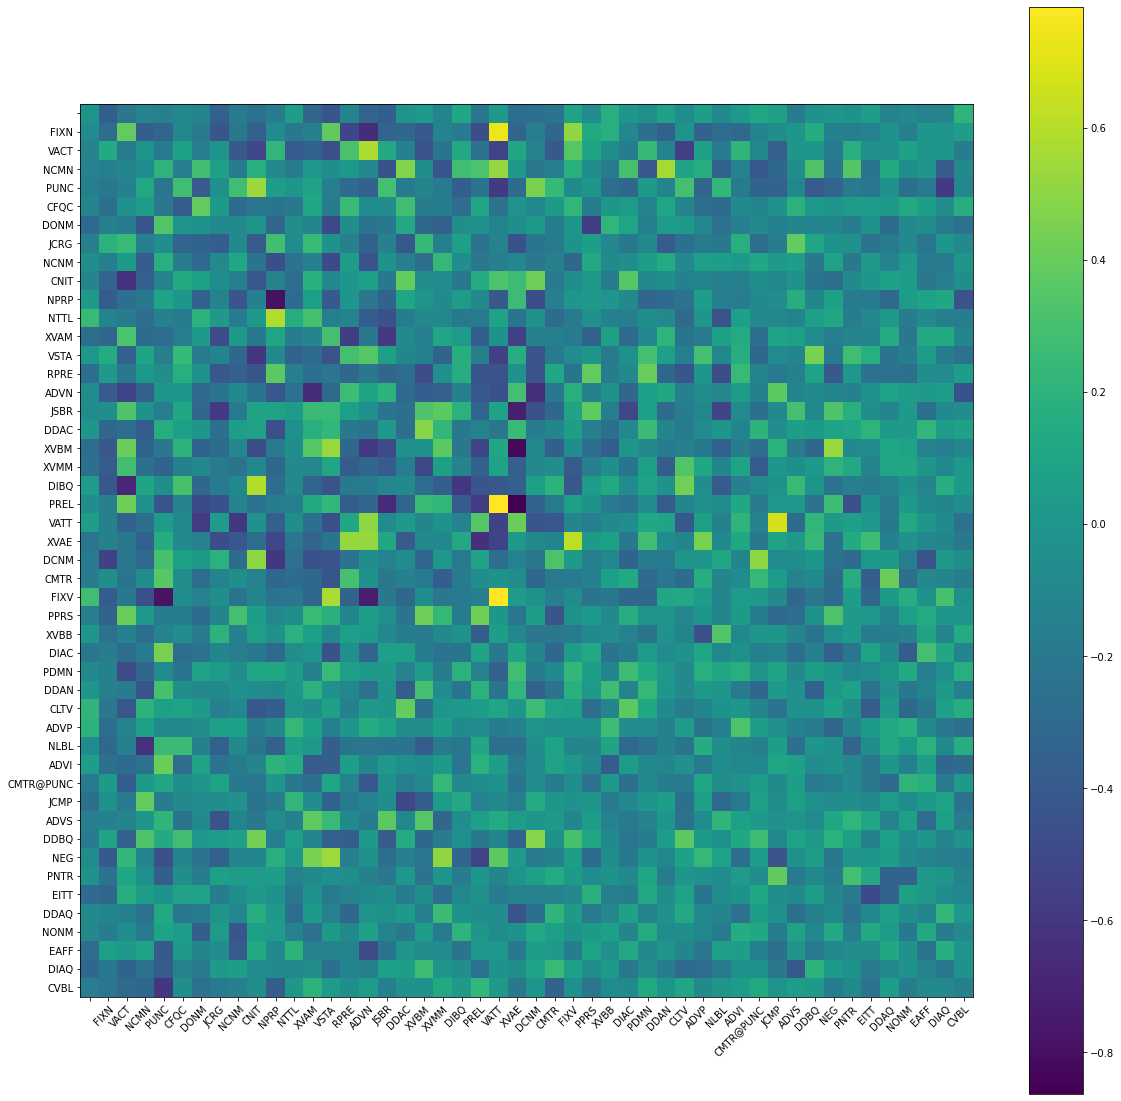

In [172]:
import numpy as np 
import matplotlib.pyplot as plt

H = crf.transitions

fig, ax = plt.subplots(1,1,figsize=(20,20))

heatmap = ax.imshow(H, interpolation='none')
fig.colorbar(heatmap)

ax.set_xticks(np.arange(48))
ax.set_yticks(np.arange(48))

ax.set_xticklabels([None] + list(label_to_idx.keys()))
ax.set_yticklabels([None] + list(label_to_idx.keys()))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

#### Why is this sensible
NCMN will likely transit to VATT, DANN, DDAC which makes sense.<br>

NCMN: Common noun e.g. หนังสือ, อาหาร, อาคาร, คน
followed by<br>
- VATT: Attributive verb e.g. อ้วน, ดี, สวย
- DDAN: Definite determiner, after noun without
classifier in between e.g. ยี่, นั่น, โน่น, ทั้งหมด
- DDAC: Definite determiner, allowing classifier
in between e.g. นี้, นั้น, โน้น, นู้น



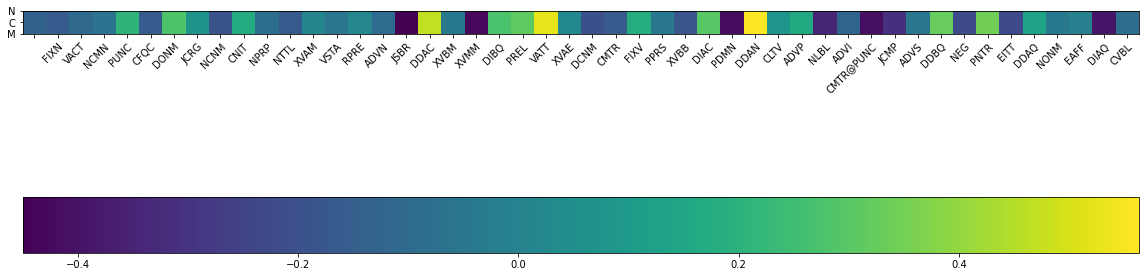

In [180]:
import numpy as np 
import matplotlib.pyplot as plt

H = crf.transitions

fig, ax = plt.subplots(1,1,figsize=(20,20))

heatmap = ax.imshow(H[3].numpy().reshape(1,-1), interpolation='none')
fig.colorbar(heatmap, orientation='horizontal')

ax.set_xticks(np.arange(48))

ax.set_xticklabels([None] + list(label_to_idx.keys()))
ax.set_yticklabels(idx_to_label[3])

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()